# Import Libraries

In [1]:
# IMPORTANT FOR TPU
!pip uninstall keras -y
!pip install keras==3.6.0

Found existing installation: keras 3.9.2
Uninstalling keras-3.9.2:
  Successfully uninstalled keras-3.9.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.4 MB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

E0000 00:00:1752700207.857343      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


# Hardware Setup

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver('local')  # use 'local' for Kaggle TPU
    print('Running on TPU:', tpu.cluster_spec().as_dict())
except ValueError:
    tpu = None
    print('No TPU detected, running on CPU/GPU.')

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU: {}
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1752700223.239192      10 service.cc:148] XLA service 0x570420814ca0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752700223.239255      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1752700223.239259      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1752700223.239262      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1752700223.239265      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1752700223.239268      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1752700223.239272      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1752700223.239275      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1752700223.239278      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [6]:
# Enable mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of devices: 8


# Data Loading and Processing

In [10]:
# Parameters
BATCH_SIZE_PER_REPLICA = 64
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
# GLOBAL_BATCH_SIZE = 16
print(f"{GLOBAL_BATCH_SIZE=}")

# Paths
train_tfrecord_path = "/kaggle/input/busi-crop-50p-50n/train.tfrecord"
val_tfrecord_path = "/kaggle/input/busi-crop-50p-50n/test.tfrecord"

GLOBAL_BATCH_SIZE=512


In [11]:
def count_tfrecord_examples(tfrecord_path):
    count = sum(1 for _ in tf.data.TFRecordDataset(tfrecord_path))
    return count

train_size = count_tfrecord_examples(train_tfrecord_path)
val_size = count_tfrecord_examples(val_tfrecord_path)

print("Train size:", train_size)
print("Validation size:", val_size)

Train size: 82603
Validation size: 20651


In [12]:
def parse_tfrecord(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
    }
    parsed = tf.io.parse_single_example(example, feature_description)

    # Check if image or mask is empty
    def decode_if_nonempty(encoded):
        return tf.cond(
            tf.equal(tf.strings.length(encoded), 0),
            lambda: tf.zeros([256, 256, 1], dtype=tf.uint8),  # MATCH dtype with decode_png
            lambda: tf.image.decode_png(encoded, channels=1)
        )

    image = decode_if_nonempty(parsed['image'])
    mask = decode_if_nonempty(parsed['mask'])

    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    return image, mask

In [13]:
def load_dataset(tfrecord_path, batch_size=16, shuffle=True, repeat=False):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = raw_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(1000)

    if repeat:
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

In [14]:
train_dataset = load_dataset(train_tfrecord_path, batch_size=GLOBAL_BATCH_SIZE, shuffle=True, repeat=True)
val_dataset = load_dataset(val_tfrecord_path, batch_size=GLOBAL_BATCH_SIZE, shuffle=False, repeat=True)

steps_per_epoch = train_size // GLOBAL_BATCH_SIZE
validation_steps = val_size // GLOBAL_BATCH_SIZE


for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)


for image, mask in train_dataset.take(1):  # get a single batch
    print("Image range:", tf.reduce_min(image).numpy(), "to", tf.reduce_max(image).numpy())
    print("Mask range:", tf.reduce_min(mask).numpy(), "to", tf.reduce_max(mask).numpy())

Image batch shape: (512, 256, 256, 1)
Mask batch shape: (512, 256, 256, 1)
Image range: 0.0 to 1.0
Mask range: 0.0 to 1.0


In [15]:
print(validation_steps)
print(steps_per_epoch)

40
161


In [16]:
def plot_samples(dataset):
    images, masks = next(iter(dataset))
    plt.figure(figsize=(12, 6))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    
        plt.subplot(2, 4, i+5)
        plt.imshow(masks[i].numpy().squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f"Mask {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

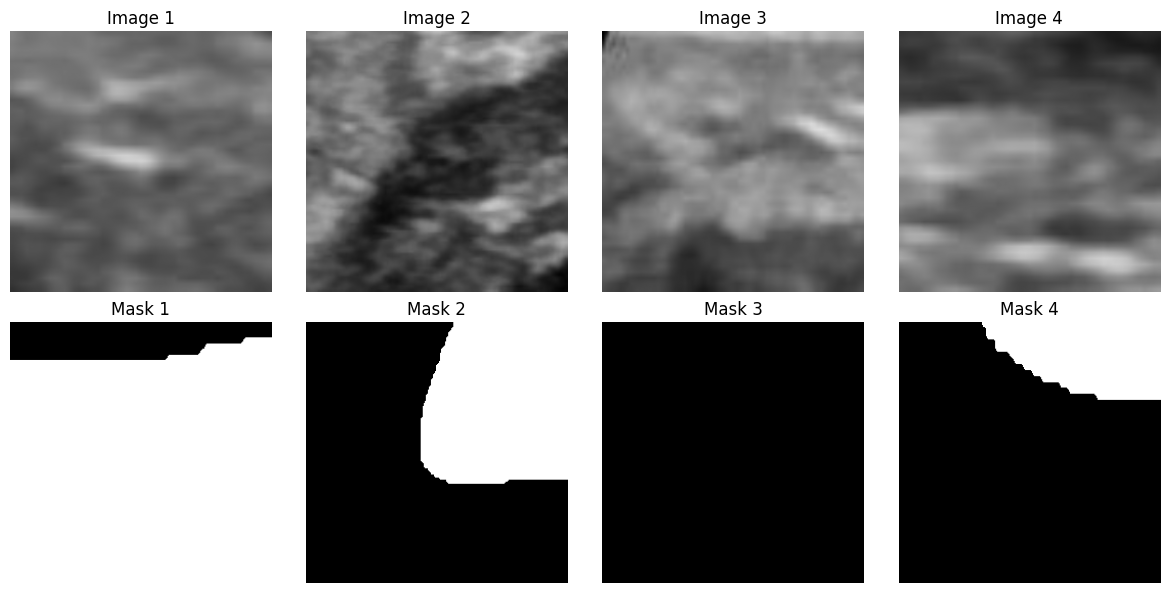

In [17]:
plot_samples(train_dataset)

# Model Loss and Metrics

In [18]:
def conv_block(input, num_filters, dropout_rate=0.1):
    conv = Conv2D(num_filters, (3, 3), padding="same")(input)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    conv = Dropout(dropout_rate)(conv)

    
    conv = Conv2D(num_filters, (3, 3), padding="same")(conv)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    conv = Dropout(dropout_rate)(conv)
    return conv

def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

def unet_model(input_shape):
    input_layer = Input(input_shape)
    
    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

In [19]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    sum_values = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    return tf.where(
        tf.equal(sum_values, 0),
        1.0,  # Perfect match if both are empty
        (2. * intersection + smooth) / (sum_values + smooth)
    )

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred - y_true * y_pred, axis=[1, 2, 3])
    
    jaccard = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(jaccard)

In [20]:
def focal_dice_loss(y_true, y_pred):
    focal_loss = tf.keras.losses.binary_focal_crossentropy(y_true, y_pred, gamma=2.0)
    dice_loss = 1.0 - dice_coef(y_true, y_pred)
    return 0.5 * focal_loss + 0.5 * dice_loss

In [22]:
with strategy.scope():   
    model = unet_model(input_shape=(256, 256, 1))
    model.summary()
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss= focal_dice_loss,
              metrics=[
                    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                    dice_coef,
                    jaccard_index,
                    tf.keras.metrics.SpecificityAtSensitivity(0.5, name='specificity'),  # Adjust sensitivity threshold if needed
                    tf.keras.metrics.Recall(name='sensitivity')  # Sensitivity is equivalent to Recall
                ])
    
    checkpointer = ModelCheckpoint('/kaggle/working/unet-tpu.weights.h5', save_best_only=True, save_weights_only=True, verbose=1)
    early_stop = EarlyStopping(patience=10, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=3,
            min_lr=1e-6,
            verbose=1)

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        640 │ cast_1[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 256, 256,  │          0 │ activation_18[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ dropout_18[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 256, 256,  │          0 │ activation_19[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ dropout_19[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128, 128,  │          0 │ activation_20[0]… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ dropout_20[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_22[0][0] 

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [23]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    steps_per_epoch=steps_per_epoch,              
    validation_steps=validation_steps,             
    callbacks=[checkpointer, early_stop, reduce_lr]
)

Epoch 1/100


I0000 00:00:1752700553.509869      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:16401572725247667300
E0000 00:00:1752700554.101143      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1752700555.233392     952 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5245762066416725611), session_name()
I0000 00:00:1752700617.325268     952 tpu_compile_op_common.cc:245] Compilation of 5245762066416725611 with session name  took 1m2.091827267s and succeeded
I0000 00:00:1752700617.456978     952 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5245762066416725611), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16401572725247667300", property.function_library_fingerprint = 14099344608006777716, property.mlir_module_fingerprint = 0, property.num_replic

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6643 - dice_coef: 0.3383 - jaccard_index: 0.1385 - loss: 0.4180 - sensitivity: 0.4091 - specificity: 0.6648

I0000 00:00:1752700997.603475      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:6538134220829363122
E0000 00:00:1752700997.708103      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1752700998.149222     951 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5136527307980797146), session_name()
I0000 00:00:1752701010.601963     951 tpu_compile_op_common.cc:245] Compilation of 5136527307980797146 with session name  took 12.452678872s and succeeded
I0000 00:00:1752701010.613844     951 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5136527307980797146), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6538134220829363122", property.function_library_fingerprint = 2408349822397123306, property.mlir_module_fingerprint = 0, property.num_replicas = 8, t


Epoch 1: val_loss improved from inf to 0.42557, saving model to /kaggle/working/unet-tpu.weights.h5
161/161 ━━━━━━━━━━━━━━━━━━━━ 506s 3s/step - accuracy: 0.6646 - dice_coef: 0.3384 - jaccard_index: 0.1385 - loss: 0.4179 - sensitivity: 0.4092 - specificity: 0.6652 - val_accuracy: 0.7718 - val_dice_coef: 0.2868 - val_jaccard_index: 0.1128 - val_loss: 0.4256 - val_sensitivity: 0.0000e+00 - val_specificity: 0.4243 - learning_rate: 1.0000e-04
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7500 - dice_coef: 0.3940 - jaccard_index: 0.1574 - loss: 0.3749 - sensitivity: 0.5139 - specificity: 0.8270
Epoch 2: val_loss improved from 0.42557 to 0.42273, saving model to /kaggle/working/unet-tpu.weights.h5
161/161 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - accuracy: 0.7501 - dice_coef: 0.3940 - jaccard_index: 0.1574 - loss: 0.3749 - sensitivity: 0.5140 - specificity: 0.8270 - val_accuracy: 0.7322 - val_dice_coef: 0.3097 - val_jaccard_index: 0.1308 - val_loss: 0.4227 - val_sensitivity: 0.

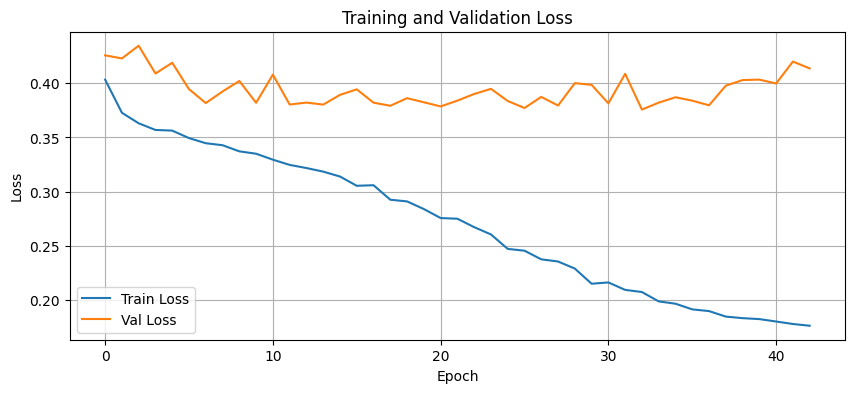

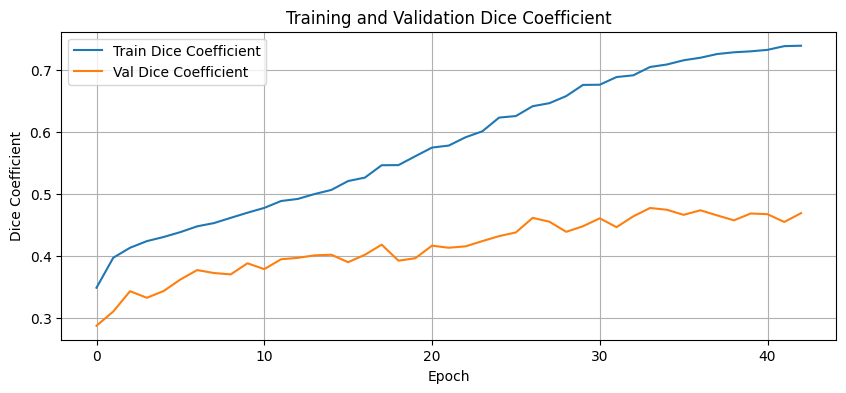

In [24]:
# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Dice Coefficient
plt.figure(figsize=(10, 4))
plt.plot(history.history["dice_coef"], label="Train Dice Coefficient")
plt.plot(history.history["val_dice_coef"], label="Val Dice Coefficient")
plt.title("Training and Validation Dice Coefficient")
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from IPython.display import FileLink
FileLink(r'unet-tpu.weights.h5')

/kaggle/working/unet-tpu.weights.h5